In [1]:
import sys
sys.path.append('../')

import copy
import glob

from typing import Tuple, Union, List
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm as tqdm

import torch
import torch.nn as nn

import torch_geometric as pyg
from torch_geometric.utils.convert import from_networkx

from src.utils import *
from dataset import *
from src.train import train, test
from src.scalers import StandardScaler as Scaler
from src.dataloaders import make_dataloaders_from_dataset, make_dataloaders_from_datasets
from src.model import BaseEstimator

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
G = nx.readwrite.read_gpickle('data/network.gpickle')

In [3]:
node_attrs = list(next(iter(G.nodes(data=True)))[-1].keys())
node_attrs = node_attrs[-20:-18] + node_attrs[3:5]
# node_attrs = node_attrs[3:]
pyg_graph = from_networkx(G, group_node_attrs=node_attrs)
pyg_graph.to(device)
print(node_attrs)

['median_income', ' population', 'labor_force_rate', 'housing_sales_num_Total:']


In [4]:
pyg_graph.x = Scaler().fit_transform(pyg_graph.x)
pyg_graph.x.shape

torch.Size([373, 4])

In [5]:
pyg_graph.x[0]

tensor([-0.2044,  0.9894,  0.7052, -0.5941], device='cuda:0')

In [6]:
class LocationScaler(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.hidden_dim = hidden_dim

        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            # nn.Linear(self.hidden_dim, self.hidden_dim),
            # nn.LeakyReLU(),
            # nn.Dropout(0.5),
            nn.Linear(self.hidden_dim, 1),
            nn.ReLU()
        )

    def forward(self, X):
        out = self.layers(X)
        # out = torch.exp(out)
        return out


class Estimator(BaseEstimator):
    def __init__(self, pyg_graph: pyg.data.Data, obs_nodes, obs_targets) -> None:
        super().__init__(pyg_graph, obs_nodes, obs_targets)

        self.loc_scaler = LocationScaler(self.g.x.shape[-1])
    
    def forward(self, loc_a):
        loc_indices = torch.as_tensor(self.node_to_idx(loc_a)).to(device)

        loc_emb = self.g.x[loc_indices]
        
        out = self.loc_scaler(loc_emb)
        # out = torch.exp(out)

        # print(self.loc_scaler(loc_b_emb))
        
        return out.reshape(-1)


In [7]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, y):
        return torch.sqrt(self.mse(pred, y))

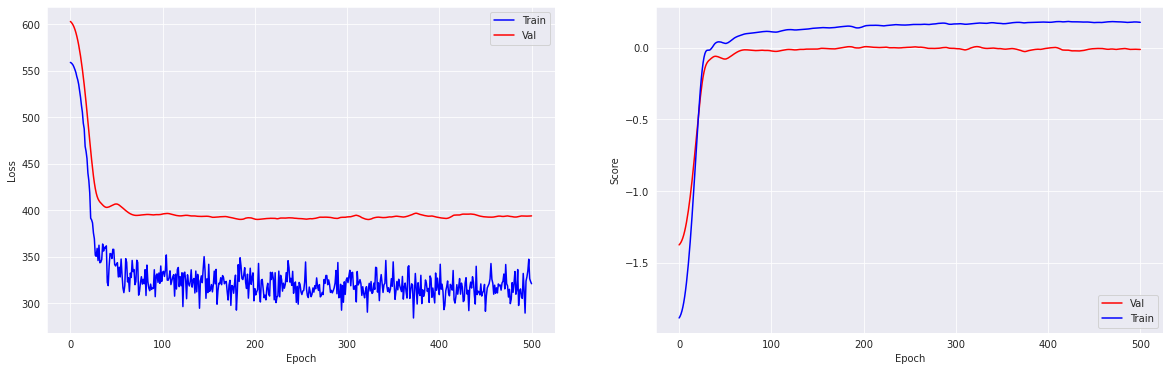

Test loss: 330.8284, test score: -0.2157


In [8]:
import datetime
# loss_fn = nn.HuberLoss(delta=200).to(device)

loss_fn = RMSELoss().to(device)
model = None


ds = torch.load('datasets/2021-01-08.dat')

train_loader, val_loader, test_loader = make_dataloaders_from_dataset(ds, batch_size=128)
train_batches = [batch for batch in train_loader]
train_nodes = [n for batch in train_batches for n in batch[0]]
train_targets = torch.cat([batch[1] for batch in train_batches])
    
if model is None:
    model = Estimator(pyg_graph, train_nodes, train_targets).to(device)
else:
    model.set_observations(train_nodes, train_targets)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.9)

model = train(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=500, plot=True)
test_loss, test_score = test(model, test_loader, loss_fn, device)
print(f'Test loss: {test_loss:.4f}, test score: {test_score:.4f}')

In [9]:
# ds = torch.load('datasets/mean.dat')
# train_loader, val_loader, test_loader = make_dataloaders_from_dataset(ds, batch_size=64)
test(model, test_loader, loss_fn, device)

for (x1, y1) in train_loader:
    print(np.asarray(model(x1).detach().cpu().numpy()) - y1.numpy())
    print()
    break



[ 1.19619904e+02  1.84558319e+02  1.44964539e+02  1.11721436e+02
 -1.75789856e+02 -4.42210388e+01  3.01239014e-01 -4.29978241e+02
  2.23855591e+02  3.79272827e+02  4.19682007e+01 -4.88008331e+02
 -1.50938873e+02  1.42048920e+02 -2.53894043e+01  5.67249817e+02
  8.75175476e+01 -6.60031799e+02 -4.40335693e+01  2.44281433e+02
  3.26546295e+02  1.15734253e+01  5.93530884e+01  3.86638489e+01
 -9.00074341e+02  2.18666168e+02 -5.37064575e+02  5.35458374e+01
  2.52441559e+02 -2.22242432e+01  1.64171448e+02 -1.95547852e+02
  1.02109833e+02 -3.10544434e+01 -1.24745087e+02 -3.00504608e+02
  2.49007599e+02 -4.94878235e+01 -1.32197449e+02 -4.91511841e+01
 -2.53804260e+02  1.62270050e+02 -4.76070496e+02  2.50109833e+02
 -4.84521820e+02 -1.40584747e+02 -2.06821106e+02 -4.10072632e+02
 -3.45280457e+02  8.55829773e+01  3.44474091e+02  3.36523926e+02
 -3.44481812e+01  4.12376617e+02 -3.94542786e+02  1.81055283e+02
  4.35505371e+02  4.17197510e+02  2.37675537e+02 -7.18335571e+01
  1.22877686e+02  3.65797

In [20]:
for name, param in model.named_parameters():
    print(name, param)

loc_scaler.layers.0.weight Parameter containing:
tensor([[-5.9300, -1.8102,  2.4042, -1.3079],
        [ 0.4712,  2.0484, -2.2273, -0.5155],
        [-0.2133,  2.5815, -2.1325, -0.7913],
        [-1.0980,  3.5597, -3.8546,  0.5731],
        [ 0.2117,  2.8212, -3.7085, -0.3852],
        [ 2.4562, -5.1011,  3.4062, -1.5942],
        [-0.4214,  0.4572,  2.4569, -0.5600],
        [-3.3250, -2.6763,  3.2972, -1.4318],
        [-6.4311, -1.6964,  2.9764, -0.9573],
        [-0.5327,  2.5888, -2.7233, -0.7487],
        [-2.9979, -1.2375,  2.2469, -2.4302],
        [-5.2366, -2.2743,  1.6994, -1.4142],
        [ 0.4851,  3.4796, -4.5007,  0.1602],
        [-1.4290,  2.5637, -3.0460,  0.1042],
        [ 0.5149, -0.4999,  1.0987,  1.8658],
        [-6.2272, -2.6311,  3.3986, -1.1121],
        [-0.1304,  3.0960, -2.2699, -1.1787],
        [-0.9349,  0.3362,  1.7586, -1.0457],
        [ 2.2005,  2.6014, -2.1413,  0.8852],
        [ 0.2105,  1.6739,  0.8936,  0.2776],
        [ 6.9777, -2.3183,  3.4

In [21]:
import datetime
# loss_fn = nn.HuberLoss(delta=50).to(device)
loss_fn = nn.MSELoss().to(device)
# model = None

for path in tqdm(glob.glob('datasets/*')[:]):
    try:
        day = path.split('/')[1].split('.')[0]
        day_num = datetime.datetime.strptime(day, '%Y-%m-%d').weekday()
        workday = day_num < 5
        
        if not (workday and datetime.datetime.strptime('2021-01-04', '%Y-%m-%d').weekday() < 5):
            continue
    except:
        continue

    try:
        ds = torch.load(path)
    except:
        print('ds not found')
        
    train_loader, val_loader, test_loader = make_dataloaders_from_dataset(ds, batch_size=64)
    train_batches = [batch for batch in train_loader]
    train_nodes = [n for batch in train_batches for n in batch[0]]
    train_targets = torch.cat([batch[1] for batch in train_batches])
        
    if model is None:
        model = Estimator(pyg_graph, train_nodes, train_targets).to(device)
    else:
        model.set_observations(train_nodes, train_targets)

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.9)

    test_loss, test_score = test(model, test_loader, loss_fn, device)

    # for name, param in best_model.named_parameters():
        # print(name, param)

    print(f'{day}, Test loss: {test_loss:.4f}, test score: {test_score:.4f}')

    # model = train(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=40, plotting=False)
    # test_loss, test_score = test(model, test_loader, loss_fn, device)
    # print(f'{day}, Test loss: {test_loss:.4f}, test score: {test_score:.4f}')

  0%|          | 0/31 [00:00<?, ?it/s]

2021-01-15, Test loss: 1492888.2500, test score: -0.0503
2021-01-04, Test loss: 107663.8828, test score: -0.0455
2020-12-28, Test loss: 84854.2344, test score: 0.0298
2021-01-06, Test loss: 101905.6328, test score: 0.0021
2021-01-13, Test loss: 113658.8906, test score: -0.0183
2021-01-20, Test loss: 94746.8359, test score: -0.0117
2021-01-18, Test loss: 70412.3359, test score: -0.0375
2021-01-12, Test loss: 103038.3594, test score: -0.0223
2020-12-29, Test loss: 92529.1172, test score: 0.0248
2021-01-07, Test loss: 106641.0391, test score: -0.0308
2020-12-30, Test loss: 113156.7734, test score: -0.0546
2021-01-19, Test loss: 91064.2422, test score: -0.0150
2021-01-05, Test loss: 106810.5781, test score: -0.0053
2020-12-31, Test loss: 75417.7500, test score: -0.0217
2021-01-22, Test loss: 104013.0000, test score: -0.0022
2021-01-21, Test loss: 99974.3125, test score: -0.0243
2021-01-08, Test loss: 99992.7969, test score: -0.1107
2021-01-01, Test loss: 81819.2500, test score: -2.8166
202